# Data processing and globals

In [289]:
import csv
import datetime
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Markdown, Latex
from collections import defaultdict
from scipy.optimize import curve_fit
from scipy.special import exp10

%matplotlib notebook
%config NotebookBackend.print_figure_kwargs = {'bbox_inches': 'tight'}
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.max_open_warning'] = 0


KEY_COUNTRY = 1
KEY_DATES_START = 4
DAYS_EXTEND = 7


# Returns a proper `datetime` from `date_str` in a format like
# '1/22/20', which represents January 22nd, 2020.
def make_date(date_str):
    parts = date_str.split('/')
    assert(len(parts) == 3)
    return datetime.date(2000 + int(parts[2]), int(parts[0]), int(parts[1]))


class Country(object):
    def __init__(self, name, population, series_data):
        self.name = name
        self.population = population
        self.timeseries = series_data

    def get(self, series, perm=False):
        factor = 1000.0/self.population if perm else 1.0
        return [v*factor for v in self.timeseries[series]]
            

def read_one_data_series(series):
    country_data = dict()
    with open(f'data/{series}.csv') as fin:
        reader = csv.reader(fin, delimiter=',', quotechar='"')
        header = next(reader)
        dates = [make_date(date_str) for date_str in header[KEY_DATES_START:]]
        for line in reader:
            name = line[KEY_COUNTRY]
            vals = [int(v) for v in line[KEY_DATES_START:]]
            assert(len(vals) == len(dates))
            if name not in country_data:
                country_data[name] = vals
            else:
                # Another province/state for the same country.
                # We just sum this up.
                cur = country_data[name]
                assert(len(cur) == len(vals))
                for i in range(len(cur)):
                    cur[i] += vals[i]
    return dates, country_data


class DB(object):
    def __init__(self):
        self.dates = None
        # {country name -> {series name -> timeseries numbers}}
        per_country = defaultdict(dict)
        for series in ['confirmed', 'recovered', 'dead']:
            dates, country_data = read_one_data_series(series)
            if self.dates is None:
                self.dates = dates
            else:
                # We're assuming all the dates are present in all the datasets.
                assert(self.dates == dates)
            if len(per_country) > 0:
                assert(set(per_country.keys()) == set(country_data.keys()))
            for country, vals in country_data.items():
                per_country[country][series] = vals

        # {country name -> population}
        populations = dict()
        with open('data/country_population.txt') as fin:
            for line in fin:
                parts = line.split(' ')
                populations[' '.join(parts[:-1])] = int(parts[-1])
        # {country name -> Country}
        self.countries = dict()
        for name, series_data in per_country.items():
            try:
                pop = populations[name]
            except:
                print('Missing population for', name)
                pop = 1
            self.countries[name] = Country(name, pop, series_data)

    def country(self, country_name):
        return self.countries[country_name]


def identity(lst):
    return lst


def log(lst):
    return [None if x == 0 else math.log10(x) for x in lst]


def latex_scientific(numstr):
    p = numstr.find('e')
    if p == -1:
        return numstr
    k = numstr[:p]
    e = int(numstr[p+1:])
    return fr'{k} \times 10^{{{e}}}'


def exponential(t, a, b):
    return a * exp10(b * t)


def display_exponential(prefix, a, b):
    doubling_days = math.log10(2) / b
    latex_a = latex_scientific(f'{a:.3g}')
    display(Latex(fr'{prefix}: \({latex_a} \times 10^{{{b:.3f}t}}\) (doubling rate \({doubling_days:.1f}\) days)'))


def sigmoid(t, a, b, c):
    return a / (1.0 + exp10(-b * (t - c)))


def display_sigmoid(prefix, a, b, c):
    display(Latex(fr'{prefix}: \(\dfrac{{{a:,.1f}}}{{1 + 10^{{-{b:.3f} (t - {c:.1f})}}}}\) (asimptote \({a:,.1f}\))'))


# Returns a plt, ax pair with a size that works well with `%matplotlib notebook`.
def get_plot():
    return plt.subplots(figsize=(12, 8))


def get_start_and_align(country_name, series, start_val, perm):
    data = db.country(country_name).get(series, perm=perm)
    for i, (t, val) in enumerate(zip(db.dates, data)):
        if val >= start_val:
            return db.dates[i:], data[i:]


def country_exp_vs_sigmoid(country, series, start_cases):
    dates, data = get_start_and_align(country, series, start_cases, perm=False)
    display(Markdown(f'### {series.title()}'))
    display(Markdown(f'Start date {dates[0]} (first day with {start_cases} cases {series})'))
    display(Markdown(f'Latest number {data[-1]:,.0f} on {dates[-1]}'))
    (aexp, bexp), _ = curve_fit(exponential, np.arange(1, len(data) + 1), data, p0=(1, 0.1))
    display_exponential('Best fit exponential', aexp, bexp)
    try:
        (asig, bsig, csig), _ = curve_fit(sigmoid, np.arange(1, len(data) + 1), data, p0=(data[-1], 0.2, 21))
        display_sigmoid('Best fit sigmoid', asig, bsig, csig)
    except:
        # Sometimes we can't get a remotely good fit, so it's better to omit it. An alternative is to
        # do many iterations (set `maxfev` to a high number), but that produces really bad fits in some cases.
        asig = None

    ts_extended = np.arange(1, len(data) + 1 + DAYS_EXTEND)
    dates_extended = dates[::] + [dates[-1] + datetime.timedelta(days=d) for d in range(1, DAYS_EXTEND + 1)]
    _, ax = get_plot()
    ax.plot(dates, data, label=f'{country} {series}')
    ax.plot(dates_extended, exponential(ts_extended, aexp, bexp), label='Best fit exponential')
    if asig is not None:
        ax.plot(dates_extended, sigmoid(ts_extended, asig, bsig, csig), label='Best fit sigmoid')
    ax.set_title(f'Exponential{" and sigmoid" if asig is not None else ""} fit for {country}, starting from {start_cases} cases {series}')
    ax.legend()
    plt.tight_layout()


def country_deep_dive(country):
    display(Markdown(f'## {country}'))
    country_exp_vs_sigmoid(country, 'confirmed', start_cases=5)
    country_exp_vs_sigmoid(country, 'dead', start_cases=1)


def compare_countries_absolute_dates(series):
    display(Markdown(f'## {series.title()}'))
    _, ax = get_plot()
    for country in countries_to_plot:
        ax.plot(db.dates, log(db.country(country).get(series, perm=True)), label=country)
    ax.set_ylabel('# {} per thousand (log10)'.format(series))
    ax.legend()
    plt.tight_layout()
    

def compare_countries_relative_dates(series, start_value):
    display(Markdown(f'## {series.title()}'))

    # Arguments for the identity (i.e. linear) and log plots.
    # We do this weird thing here instead of using subplots because
    # %matplotlib notebook works poorly with subplots.
    idn_plot_args = []
    log_plot_args = []
    plot_args = [idn_plot_args, log_plot_args]
    for cidx, country in enumerate(countries_to_plot):
        # Start each country when they had some fraction of cases per thousand.
        dates, data = get_start_and_align(country, series, start_value[0], perm=True)
        data_label = f'{country} (start date {dates[0]})'
        fit_label = f'{country} best fit exponential'
        ts = np.arange(1, len(data) + 1)
        (aexp, bexp), _ = curve_fit(exponential, ts, data, p0=(1, 0.1))
        display_exponential(f'Best fit exponential {country}', aexp, bexp)
    
        for fnidx, fn in enumerate([identity, log]):
            plot_args[fnidx].append((ts, fn(data), f'C{cidx}', data_label))
            plot_args[fnidx].append((ts, fn(exponential(ts, aexp, bexp)), f'C{cidx}', fit_label))

    def plot_one(args, title):
        _, ax = get_plot()
        for ts, data, color, label in args:
            ax.plot(ts, data, color=color, label=label)
        ax.set_title(title)
        ax.legend()
        plt.tight_layout()

    plot_one(idn_plot_args, f'{series.title()} per thousand over time (days), from the 1st day with {start_value[1]}')
    plot_one(log_plot_args, f'Log10 {series} per thousand over time (days), from the 1st day with {start_value[1]}')


db = DB()
countries_to_plot = ['Croatia', 'Switzerland', 'Italy', 'US', 'United Kingdom']

Missing population for Bahamas
Missing population for Diamond Princess
Missing population for Gambia
Missing population for West Bank and Gaza
Missing population for Saint Kitts and Nevis
Missing population for Kosovo
Missing population for Burma
Missing population for MS Zaandam


In [290]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Per-country analysis with exponential and sigmoidal projections

<span style="color:red;">IMPORTANT: The projections are only accurate if the fit is good (it often isn't), and assuming nothing changes going forward. The sigmoid is omitted if a reasonable fit can't be computed, but this still doesn't mean that the fit is good if it is shown.</span>

## Croatia

### Confirmed

Start date 2020-02-28 (first day with 5 cases confirmed)

Latest number 657 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


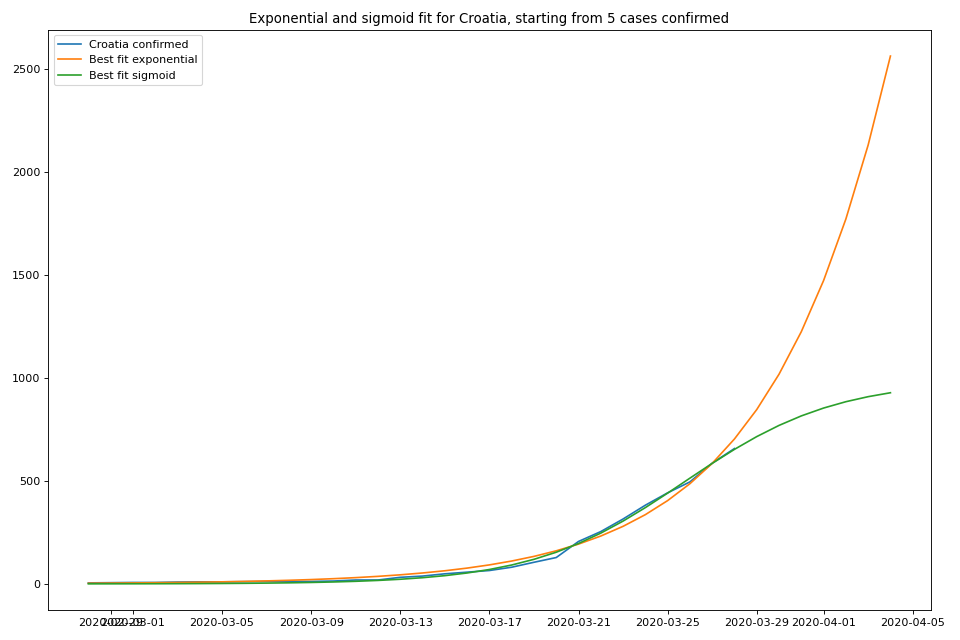

### Dead

Start date 2020-03-19 (first day with 1 cases dead)

Latest number 5 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


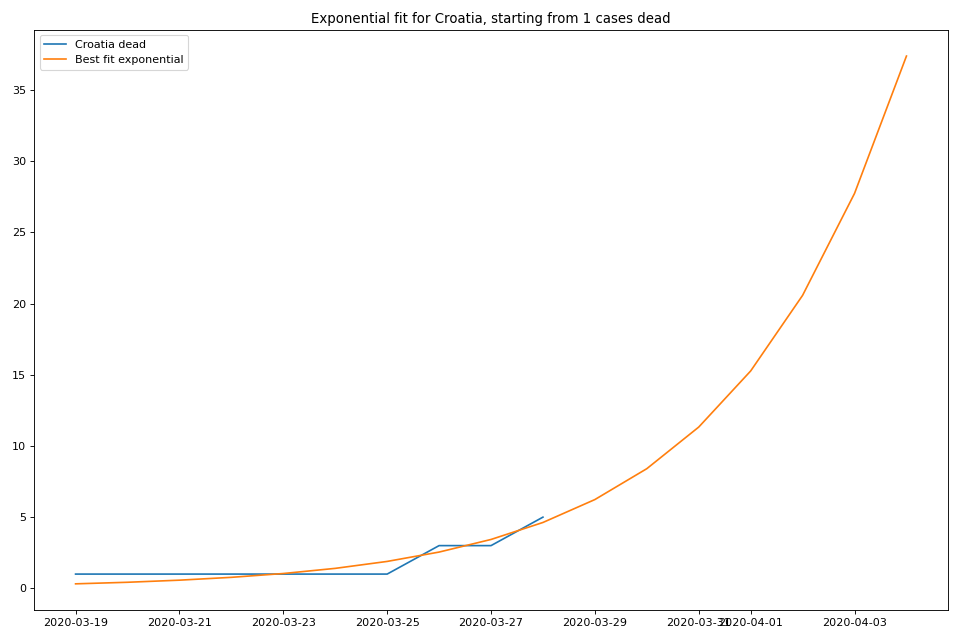

## Switzerland

### Confirmed

Start date 2020-02-27 (first day with 5 cases confirmed)

Latest number 14,076 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


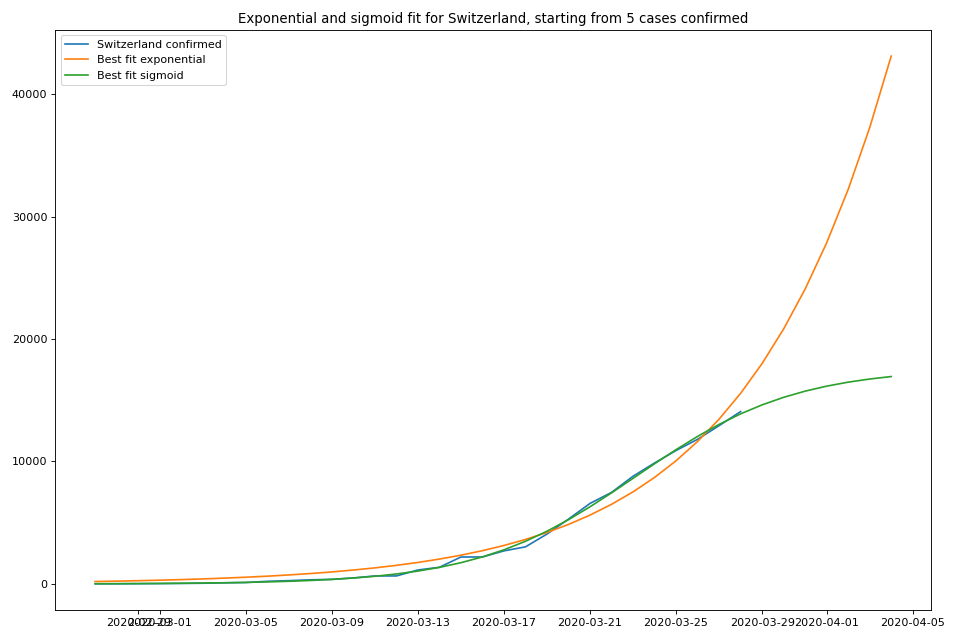

### Dead

Start date 2020-03-05 (first day with 1 cases dead)

Latest number 264 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


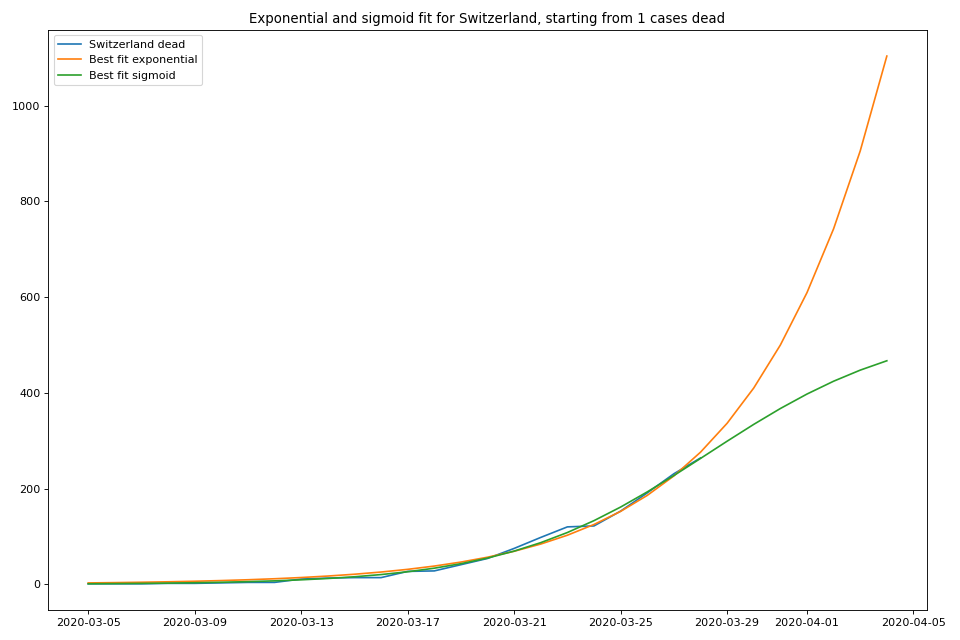

## Italy

### Confirmed

Start date 2020-02-21 (first day with 5 cases confirmed)

Latest number 92,472 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


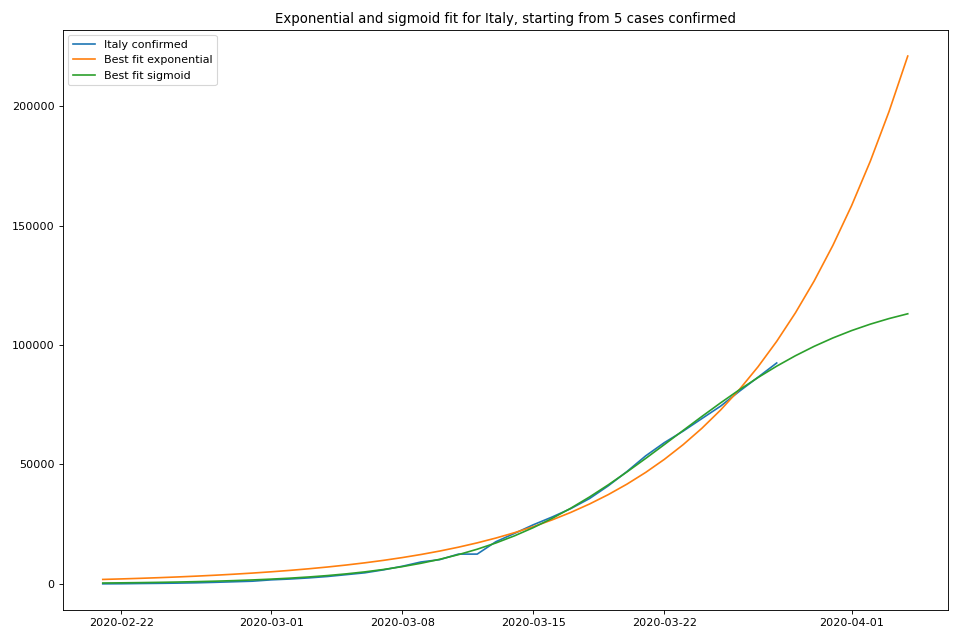

### Dead

Start date 2020-02-21 (first day with 1 cases dead)

Latest number 10,023 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


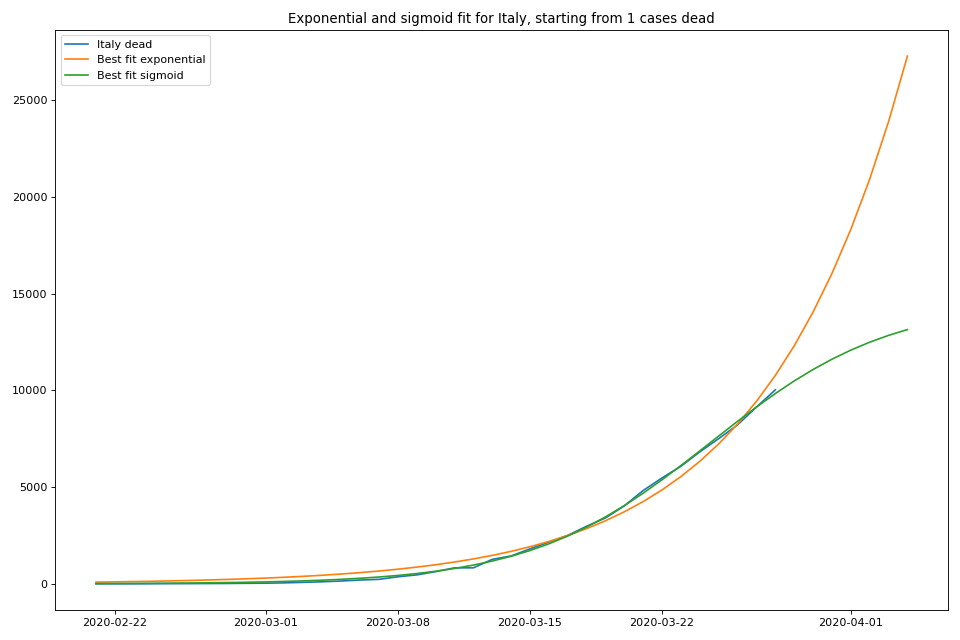

## US

### Confirmed

Start date 2020-01-26 (first day with 5 cases confirmed)

Latest number 121,478 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


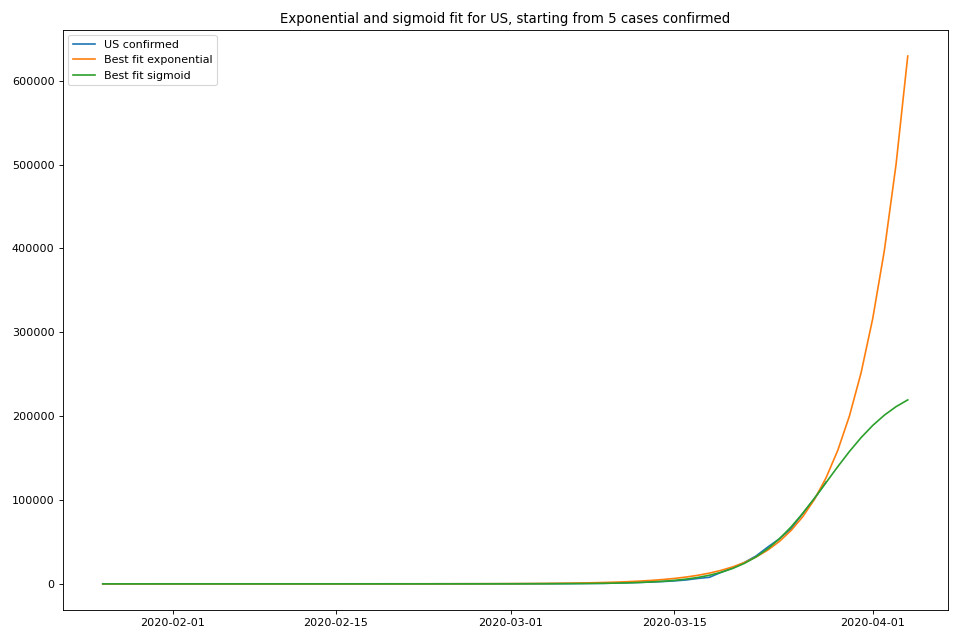

### Dead

Start date 2020-02-29 (first day with 1 cases dead)

Latest number 2,026 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


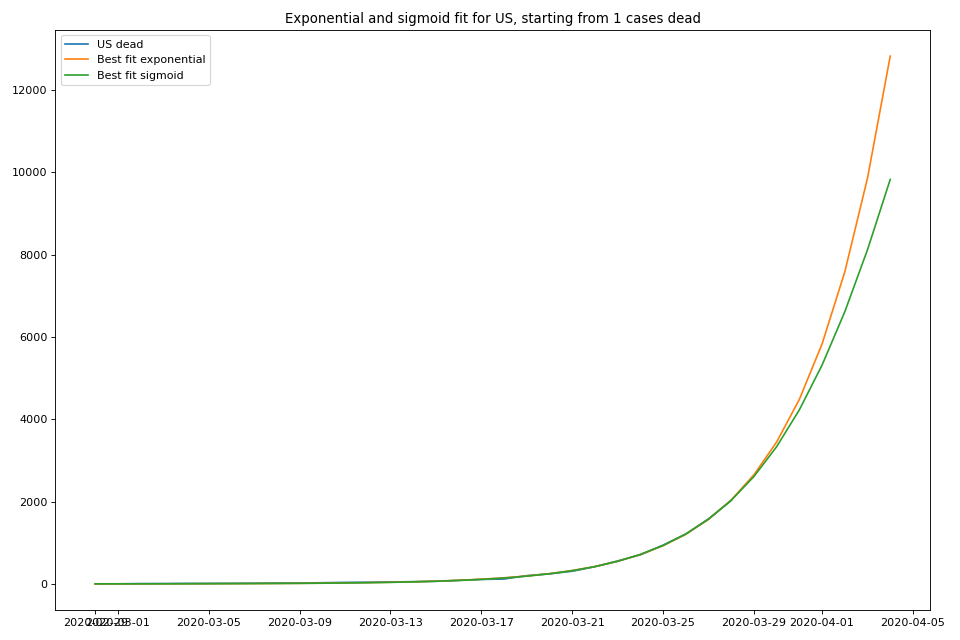

## United Kingdom

### Confirmed

Start date 2020-02-10 (first day with 5 cases confirmed)

Latest number 17,312 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


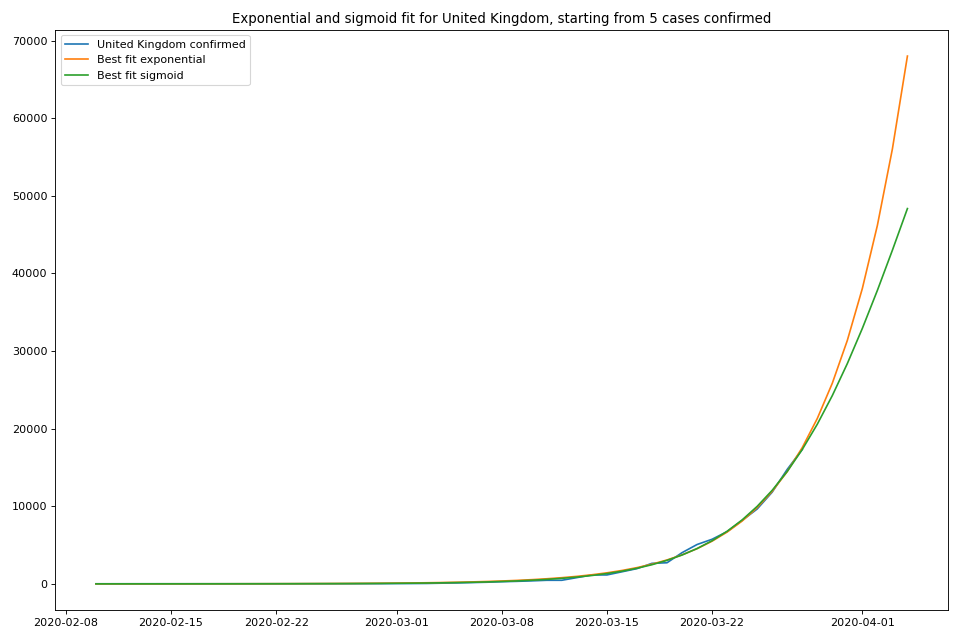

### Dead

Start date 2020-03-05 (first day with 1 cases dead)

Latest number 1,021 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


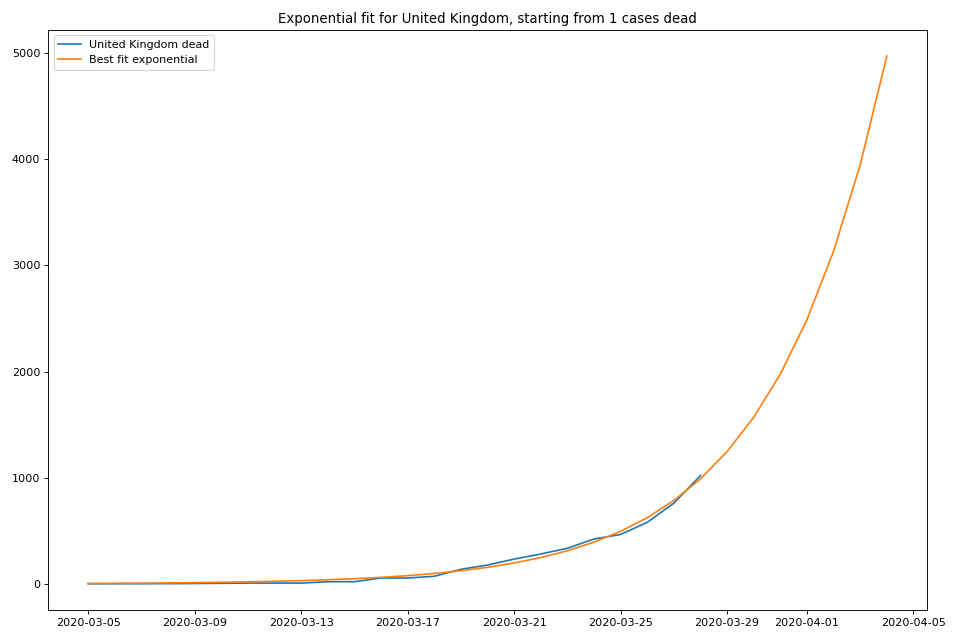

In [291]:
display(Markdown('# Per-country analysis with exponential and sigmoidal projections'))
display(Markdown('<span style="color:red;">IMPORTANT: The projections are only accurate if the fit is good'
                 + ' (it often isn\'t), and assuming nothing changes going forward.'
                 + ' The sigmoid is omitted if a reasonable fit can\'t be computed, but this still'
                 + ' doesn\'t mean that the fit is good if it is shown.</span>'))
for country in countries_to_plot:
    country_deep_dive(country)

# Recovering countries

## Korea, South

### Confirmed

Start date 2020-01-31 (first day with 5 cases confirmed)

Latest number 9,478 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


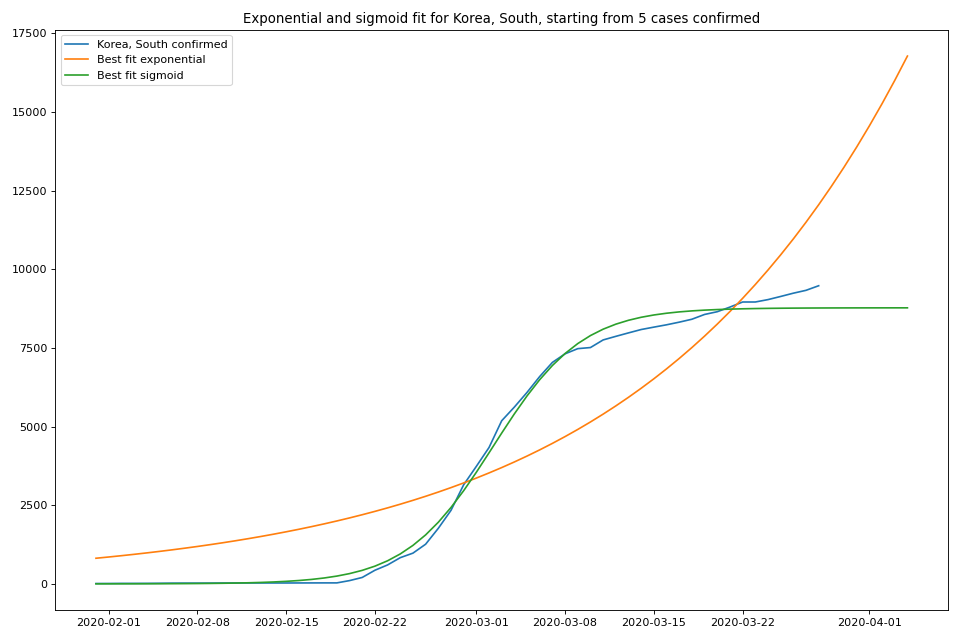

### Dead

Start date 2020-02-20 (first day with 1 cases dead)

Latest number 144 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


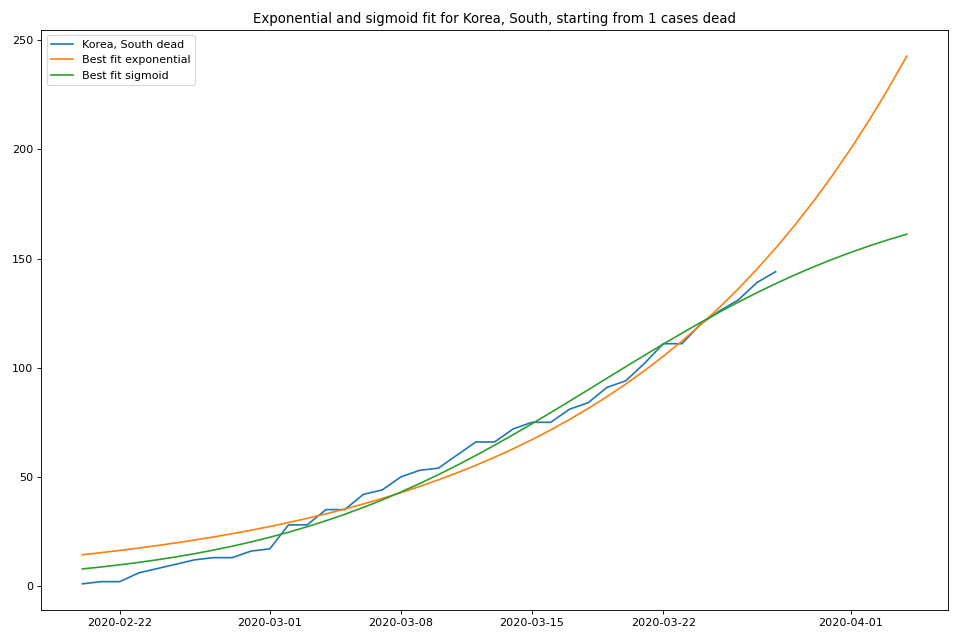

## Japan

### Confirmed

Start date 2020-01-28 (first day with 5 cases confirmed)

Latest number 1,693 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


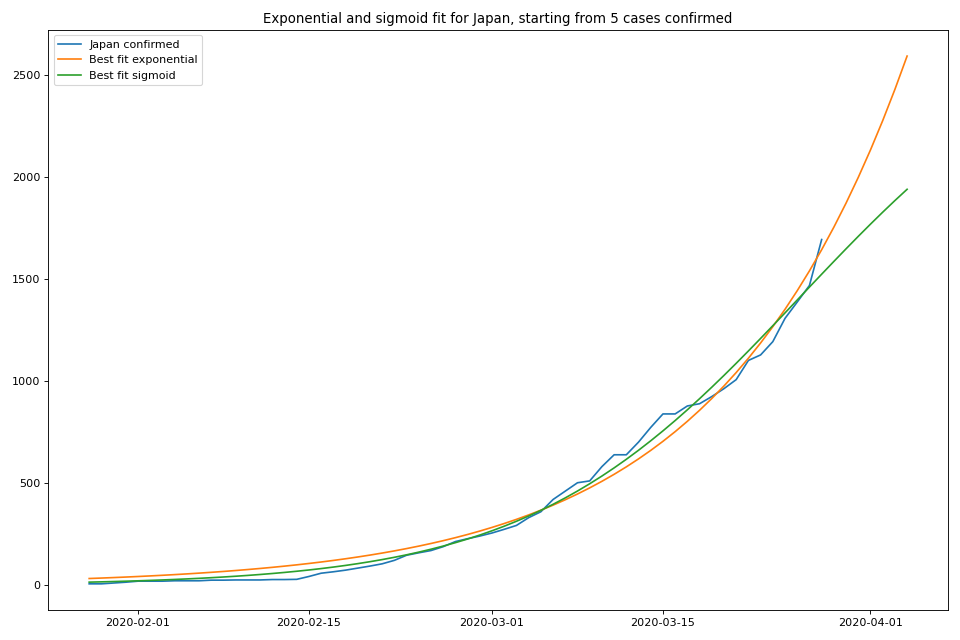

### Dead

Start date 2020-02-13 (first day with 1 cases dead)

Latest number 52 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


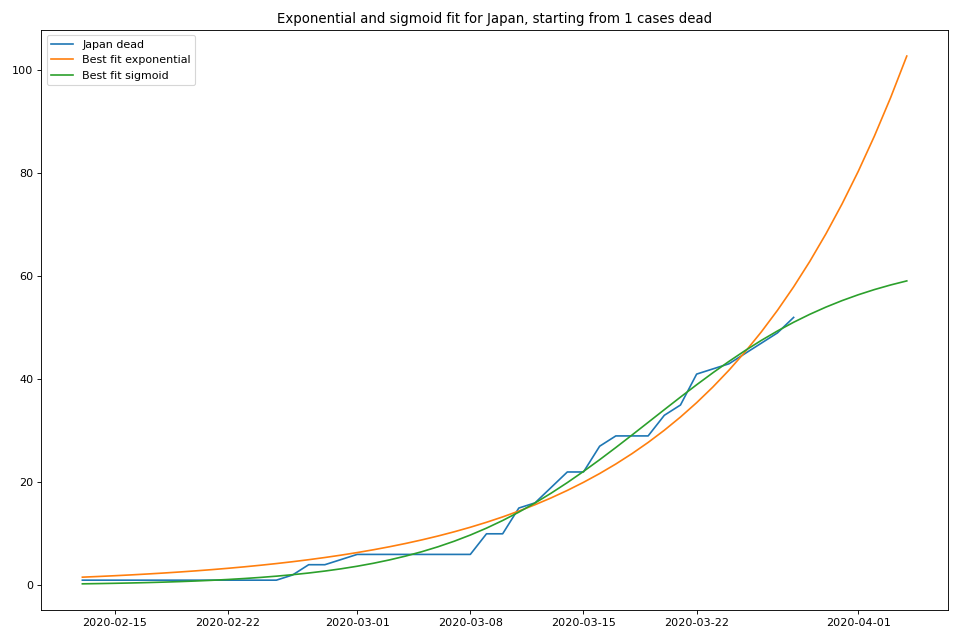

## China

### Confirmed

Start date 2020-01-22 (first day with 5 cases confirmed)

Latest number 81,999 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


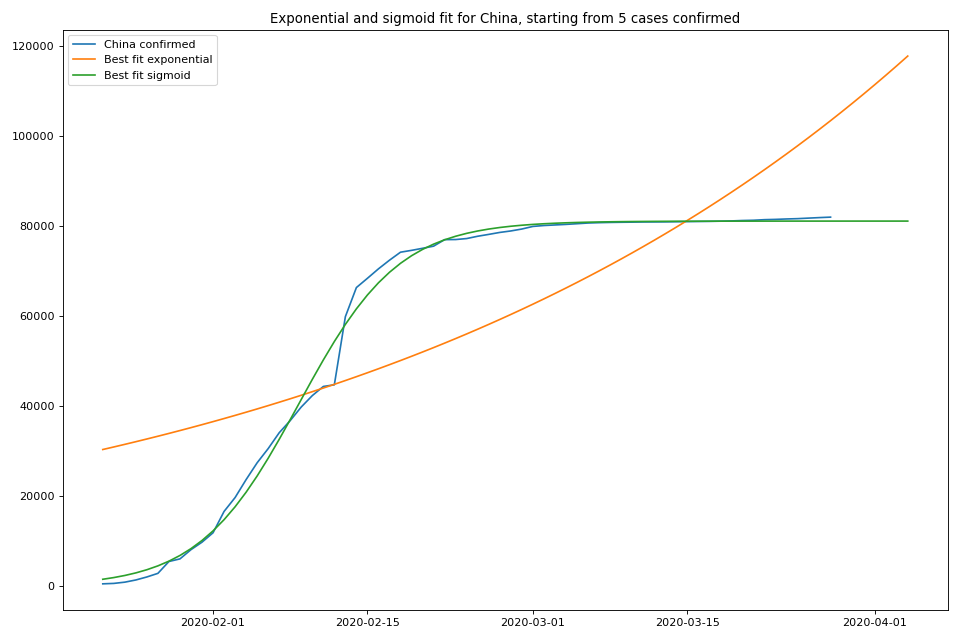

### Dead

Start date 2020-01-22 (first day with 1 cases dead)

Latest number 3,299 on 2020-03-28

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


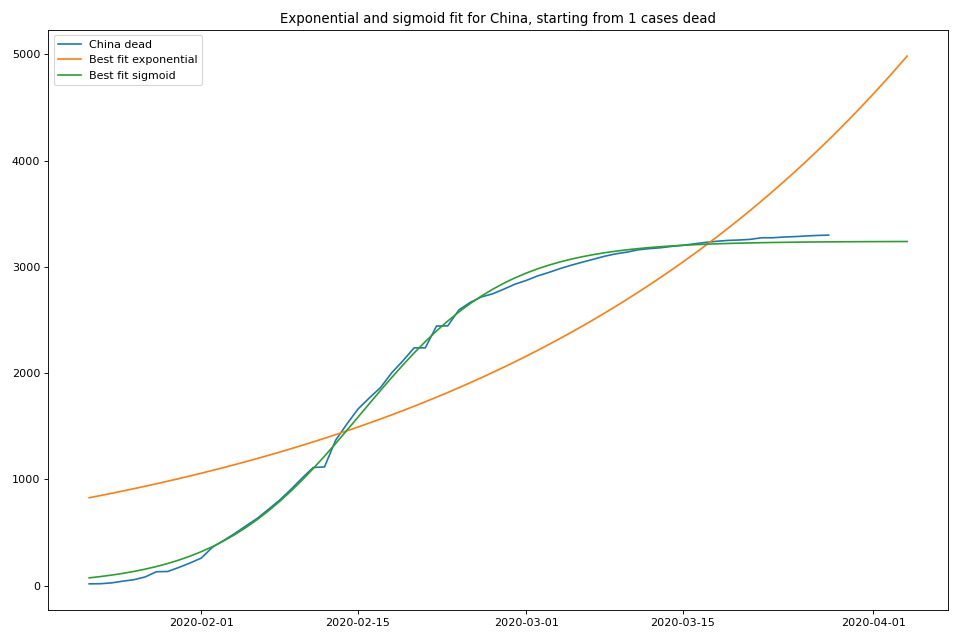

In [292]:
display(Markdown('# Recovering countries'))
recovering_countries = ['Korea, South', 'Japan', 'China']
for country in recovering_countries:
    country_deep_dive(country)

# Cross-country comparison over absolute dates

## Confirmed

<IPython.core.display.Javascript object>


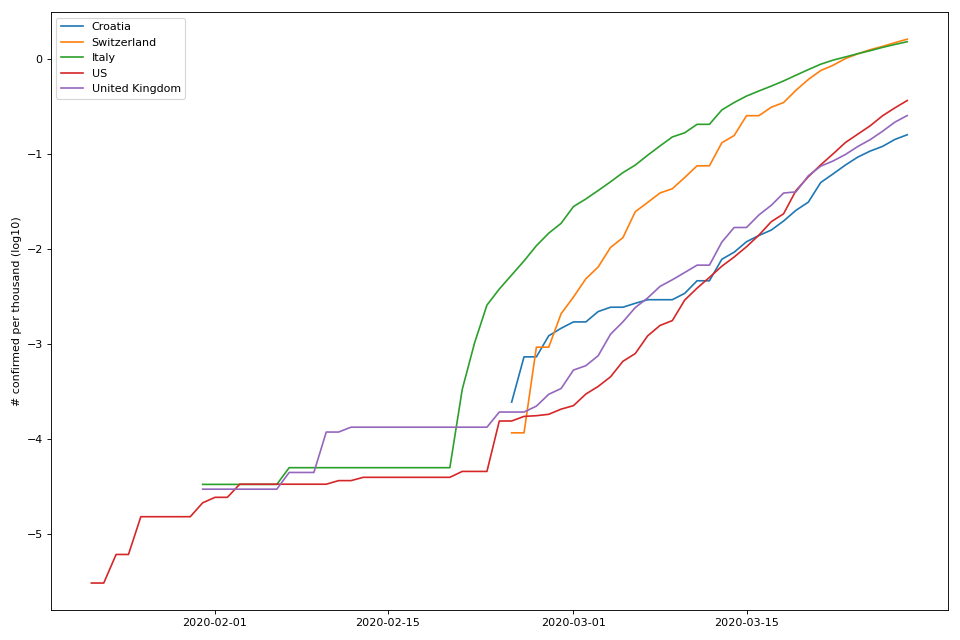

## Recovered

<IPython.core.display.Javascript object>


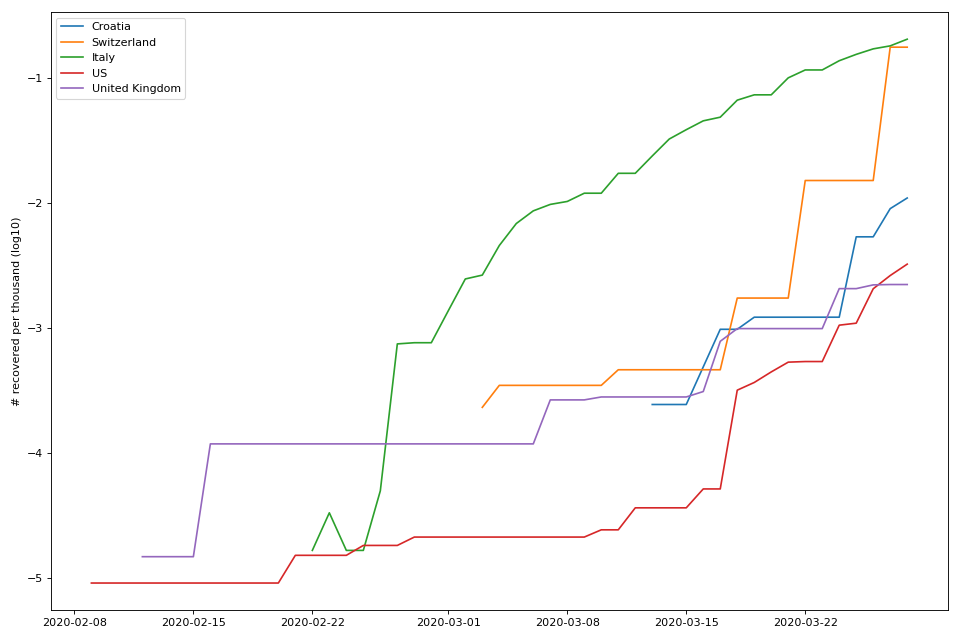

## Dead

<IPython.core.display.Javascript object>


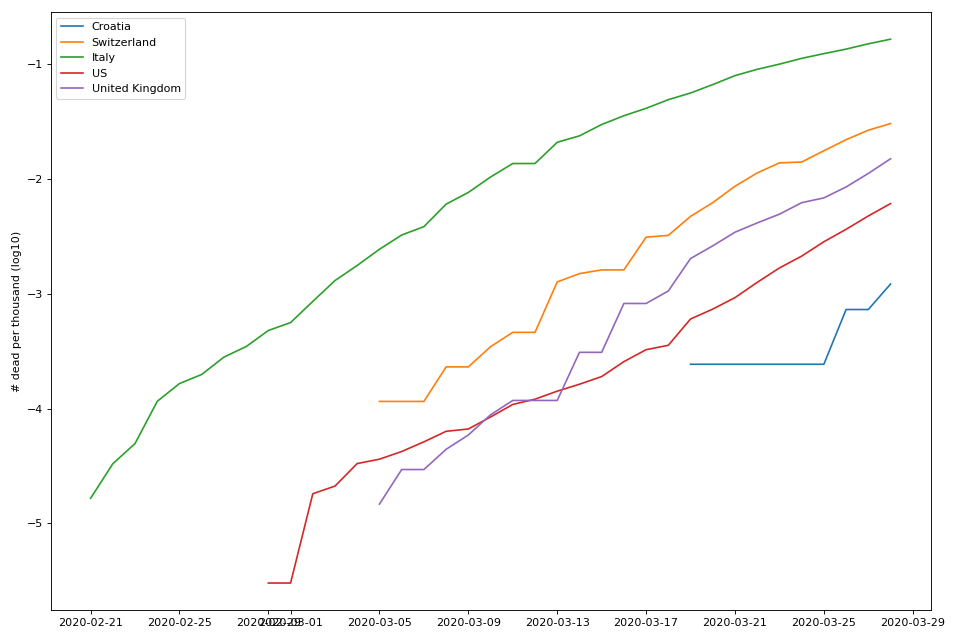

In [293]:
display(Markdown('# Cross-country comparison over absolute dates'))
for series in ['confirmed', 'recovered', 'dead']:
    compare_countries_absolute_dates(series)

# Cross-country comparison with approximately aligned start days

## Confirmed

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


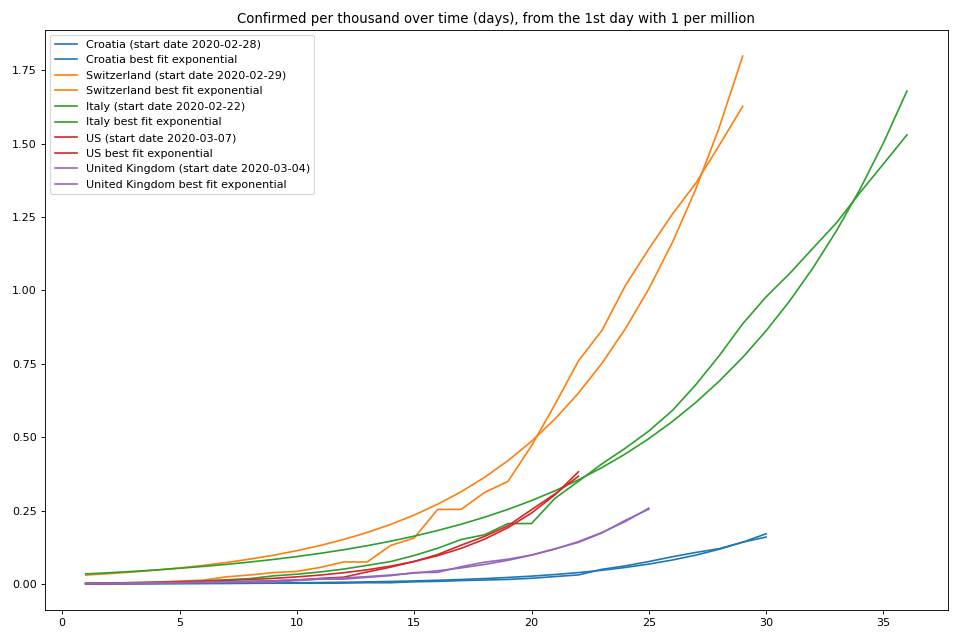

<IPython.core.display.Javascript object>


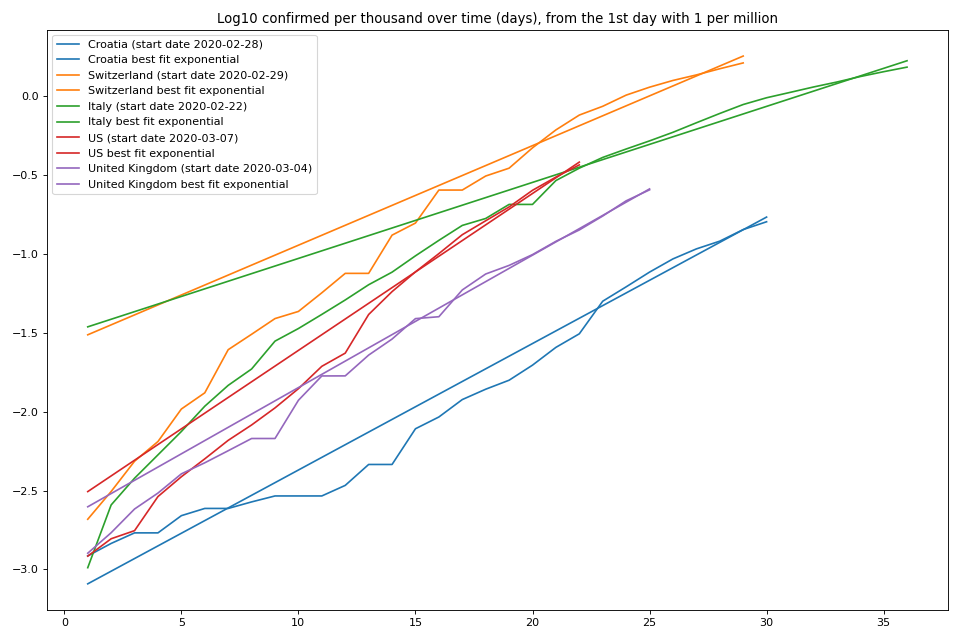

In [294]:
compare_countries_relative_dates('confirmed', start_value=(0.001, '1 per million'))

## Dead

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


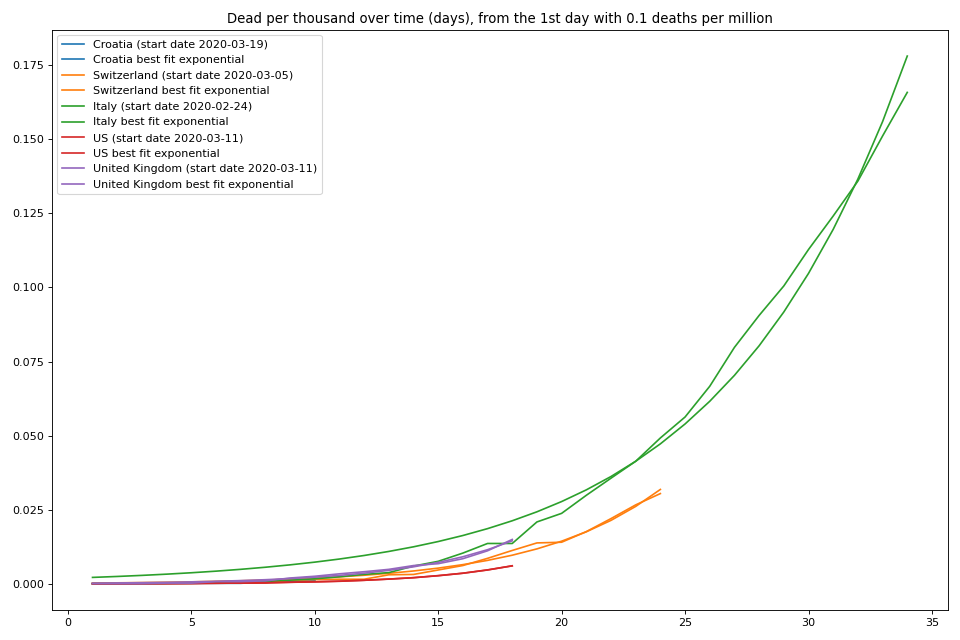

<IPython.core.display.Javascript object>


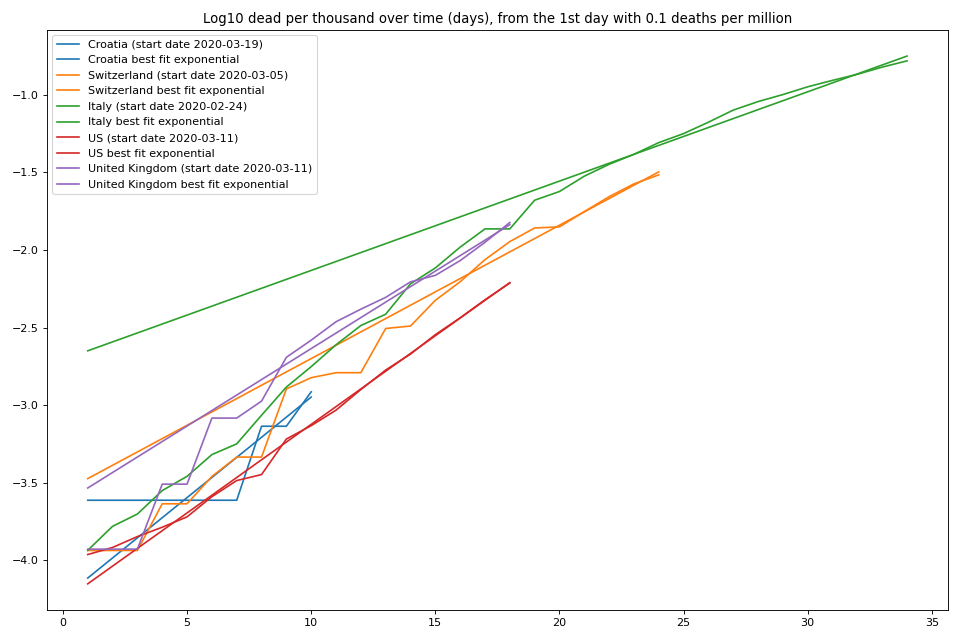

In [295]:
compare_countries_relative_dates('dead', start_value=(0.0001, '0.1 deaths per million'))